In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from statsmodels.stats.weightstats import CompareMeans, DescrStatsW

### **Читаем данные в pandas фреймы**

In [2]:
before = pd.read_csv('student_before_score.csv')
after = pd.read_csv('student_after_score.csv')
groups = pd.read_csv('student_group.csv')

### **План действий**
1. Сначала соберем все наши данные в один фрейм.
2. Посмотрим что из себя представляют наши данные.
3. Сформируем гупотезу и применим подходящий тест.
4. Интерпретируем результаы. 

### **Объеденяем наши фреймы**

По скольку наши данные связаны (имеются реляционные отношения) по student_id я выбрал использовать `merge` хотя необходимости в нем именно на этих данных нет, мы могли просто использовать `concat` или перенести необходимы колонки, также я сразу создал колонку `score_diff`. По скольку наш вопрос звучит так: повлияло ли посещение курсов на балл студентов? Мы не можем просто сравнивать результаты `after_score` нам нужно имеено **изменение**.    

In [3]:
students = (
    before
    .merge(after, on='student_id')
    .merge(groups, on='student_id')
    .assign(score_diff = lambda x: x['after_score'] - x['before_score'])
)

In [4]:
students.head()

,student_id,before_score,after_score,group,score_diff
0,1,75,92,no_course,17
1,2,81,79,course,-2
2,3,58,92,course,34
3,4,47,90,course,43
4,5,76,98,course,22


### **Что из себя представляют данные?**

осуществим группировку посмотрим на основные показатели и сделаем простенькую визуализацию распределения `score_diff`

In [5]:
(
    students
    .groupby('group')
    [['before_score','after_score','score_diff']]
    .agg(['mean','median','std'])
)

before_score                   after_score                   \
                  mean median        std        mean median       std   
group                                                                   
course       63.301230   63.5  14.625841   83.903689   84.0  8.532397   
no_course    64.519531   64.0  14.561819   85.308594   86.0  8.696586   

          score_diff                    
                mean median        std  
group                                   
course     20.602459   21.0  16.990206  
no_course  20.789062   20.0  16.681617

In [6]:
grouped = students.groupby('group') # Мы в дальнейшем будем работать с объектом группировки для удобства

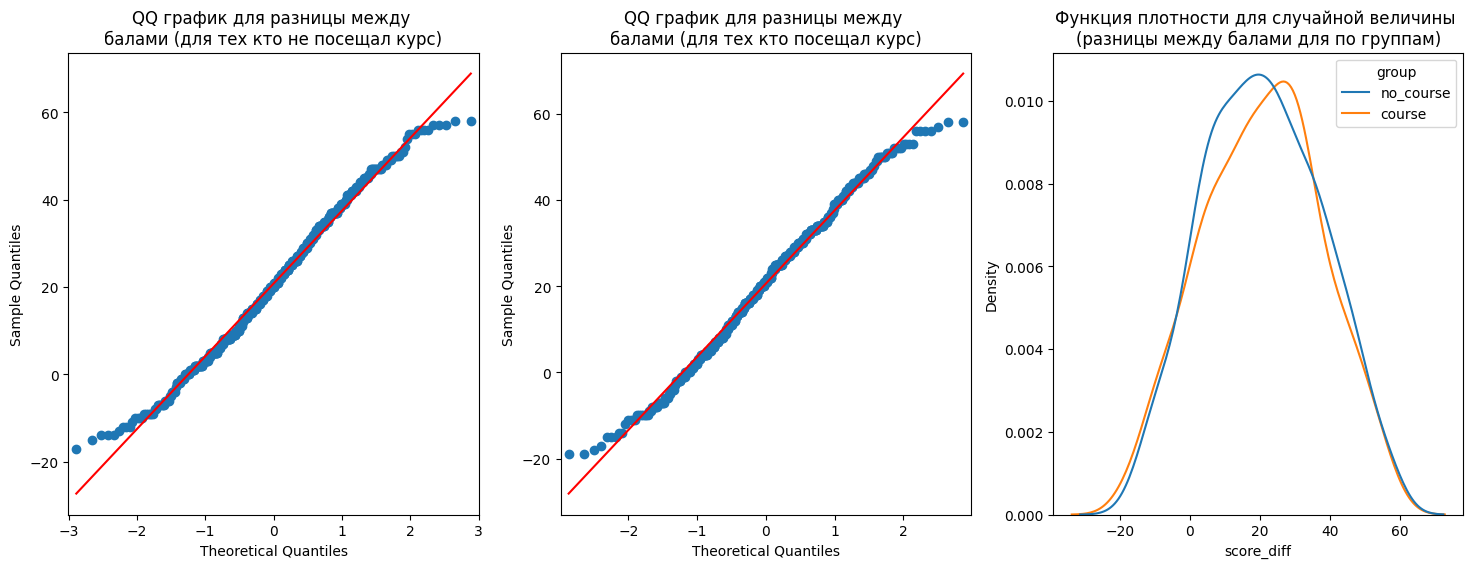

In [7]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
qqplot(grouped.get_group('no_course')['score_diff'], line='s', ax=ax[0])
qqplot(grouped.get_group('course')['score_diff'], line='s', ax=ax[1])
sns.kdeplot(students, x='score_diff',hue='group', ax=ax[2])
ax[0].set_title('QQ график для разницы между \nбалами (для тех кто не посещал курс)')
ax[1].set_title('QQ график для разницы между \nбалами (для тех кто посещал курс)')
ax[2].set_title('Функция плотности для случайной величины \n(разницы между балами для по группам)')
plt.show()

Как мы видиим по всем трем статистикам разница между группами не велика, стоит отдельно заметить что `mean` и `median` практически совпадают внутри групп, что свидельствует о симметрии распредлений. Также стандартные отклонения очень близки, это очень хорошо для параметрического тестирования, собственно наш график (функций плотности случайных величин (`score_diff`)) для двух групп выглядят приблизительно одинаково и (приблизительно Нормально). Как нам показывает QQ график. Подавляющее количество наших данных имеют нормальное распределение (Отклонение лишь в экстремальных значених). То есть допущение что нашт данные нормальны и что дисперсия в нащих группах приблизительно одинаковы, я считаю полностью уместным.

### **Гипотеза и подходящий тест**

Мы будем сравнивать **среднее значение по разнице между двумя группами**. двусторонний t-test для двух выборок. Двусторонний исходя из вопроса мы тестируем на изменение, а не на ухудшение или улучшение бала. 

Прежде чем проводить абсолютно любой тест мы должны посмотреть на сколько наши данные соответсвуют требованиям опредленного теста.
Требования для t-test.
1. Наши данные непрерывны (это очевидно)
2. Наши данные были случайно выбраны из совокупной выборки. В контексте нашего вопроса мы работаем со всеми данными, что у нас есть и случайные выборки нам из наших данных не требуются.
3. Наши выборки имеют приблизительно нормальное распределние (Вышеуказынные графики позволяют нам сделать такое допущение)
4. Схожесть вариативности внутри наших выборок (Вышеуказынные графики позволяют нам сделать такое допущение)

$$H_0: \mu_1 - \mu_2 = 0$$
$$H_1: \mu_1 - \mu_2 \neq 0$$

Где $\mu_1$ Это Средння разница между баллами для тех кто не проходил курс и соответсвенно $\mu_2$ Это средняя разница между балами для тех кто проходил курс. Также всегда до теста нам нужно выбрать порог отсечения $\alpha$ я его оставлю без изменений $\alpha=0.05$.  

In [8]:
cm = CompareMeans(
    d1=DescrStatsW(
        data= grouped.get_group('no_course')['score_diff']),
    d2=DescrStatsW(
        data= grouped.get_group('course')['score_diff']) 
         
)

In [9]:
print(cm.summary())

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      0.1866      1.065      0.175      0.861      -1.903       2.276


### **Интерпретируем результаты**

Итого мы имеем наш репорт относительно тестирования. Наша средняя разница  $0.1866$. Является ли это значение статичтически значимым отклонением от $0$. Результаты теста показывают $p$-значение очень большое $0.861$. Что означет С учетом что нулевая гипотезы истинна, это **очень вероятный исход** увидеть значение $0.861$ что означет $\approx 86\%$  увидеть значение $0.1866$ нашу разницу. Так же мы имеем $95\%$ интервал уверенности на котором нулевая гипотеза истинна. И мы видиим что наше значение с большим запасом входит в этот интервал. 

Наше исследование показало, что у нас **нет оснований** для того что бы говорить, что посещение курсов повлияло на бал студентов.